<a href="https://colab.research.google.com/github/piers-hinds/sgd_noise/blob/main/notebooks/swgd_init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+'https://github.com/piers-hinds/sgd_noise' &> /dev/null

In [2]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
from sgd_noise import *
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [146]:
n = 100
sigma = 0.10
true_theta = 0.9

torch.manual_seed(3)
noise = torch.randn(n) * sigma
xs = torch.linspace(0, 1, n)
ys = true_theta * xs + noise

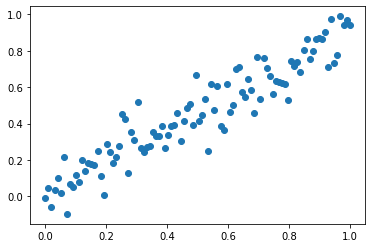

In [147]:
plt.scatter(xs, ys)

In [148]:
def model(theta, x):
    # 1d linear model
    return theta * x

def sq_err(x, y):
    return (x - y)**2

Veirfy empirical variance mathces with analytical variance:


1.   Fix a $\theta$
2.   Sample gradients and compute sample variance
3.   Evaluate analytical expression using autograd



In [149]:
theta_fixed = torch.tensor(0., requires_grad=True)

def sample_gradient(num_samples, b):
    grads = []
    np.random.seed(1)
    for i in range(num_samples):
        idx = np.random.choice(np.arange(n), b)
        loss = sq_err(model(theta_fixed, xs[idx]), ys[idx]).mean(-1)
        grad = torch.autograd.grad(loss, theta_fixed)[0]
        grads.append(grad)
    return torch.stack(grads)

In [150]:
sample_grads = sample_gradient(1000, 7)

In [151]:
sample_grads.mean()

tensor(-0.6037)

In [152]:
torch.autograd.grad(sq_err(model(theta_fixed, xs), ys).mean(-1), theta_fixed)

(tensor(-0.6069),)

In [153]:
sample_grads.var()

tensor(0.0424)

In [193]:
vars = np.stack([sample_gradient(10000, b).var().numpy() for b in range(1, 21)])

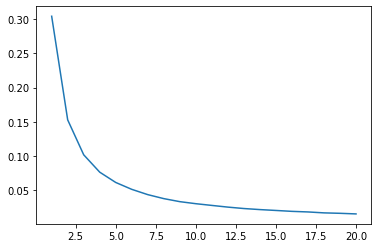

In [199]:
plt.plot(np.arange(1, 21), vars)

In [197]:
def lm_grad_variance(n, b, xs, ys):
    alphas = torch.ones_like(xs) / b
    diag_coef = b * (1 - b / n) / n
    off_diag_coef = b * ((b - 1) / (n - 1) - b / n) / n
    diag_sum = 4 * torch.sum((alphas ** 2) * (xs ** 2) * (ys ** 2))
    off_diag_sum = 4 * (torch.outer(alphas, alphas) * torch.outer(xs, xs) * torch.outer(ys, ys)).sum(-1).sum(-1) - diag_sum
    return (diag_coef * diag_sum + off_diag_coef * off_diag_sum)

In [198]:
true_vars = np.stack([lm_grad_variance(n, b, xs, ys) for b in range(1, 21)])
true_vars

array([0.30640495, 0.15165499, 0.10007165, 0.07428   , 0.058805  ,
       0.04848833, 0.04111928, 0.03559249, 0.03129388, 0.027855  ,
       0.02504136, 0.02269666, 0.02071269, 0.01901214, 0.01753833,
       0.01624875, 0.01511088, 0.01409944, 0.01319447, 0.01238   ],
      dtype=float32)

In [195]:
vars

array([0.3042194 , 0.15279536, 0.1017401 , 0.07636832, 0.06131709,
       0.05125782, 0.0435285 , 0.03770403, 0.03328008, 0.03028652,
       0.02777149, 0.0252997 , 0.02322738, 0.02168408, 0.0204157 ,
       0.01909791, 0.01824373, 0.01688034, 0.01624987, 0.01536004],
      dtype=float32)